In [9]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [10]:
# Load Data and Model
df = pd.read_csv('featured_real_estate_data.csv')

# Load best model
with open('model_info.pkl', 'rb') as f:
    model_info = pickle.load(f)

best_model_file = [f for f in ['best_model_random_forest.pkl', 'best_model_gradient_boosting.pkl', 
                                'best_model_xgboost.pkl', 'best_model_decision_tree.pkl'] 
                   if f.replace('best_model_', '').replace('.pkl', '').replace('_', ' ').title() == model_info['best_model_name']][0]

with open(best_model_file, 'rb') as f:
    best_model = pickle.load(f)

with open('feature_columns.pkl', 'rb') as f:
    feature_columns = pickle.load(f)

print(f"📁 Dataset loaded: {df.shape}")
print(f"🤖 Best Model: {model_info['best_model_name']}")
print(f"📊 Model Accuracy (R²): {model_info['test_r2_score']:.2%}")

📁 Dataset loaded: (2247, 28)
🤖 Best Model: Random Forest
📊 Model Accuracy (R²): 92.82%


## 🏗️ Use Case 1: Best Localities for Affordable Housing Development

**Business Question:** Where should builders develop budget-friendly residential projects to maximize demand and profitability?

**Target:** Builders and Developers

**Criteria:**
- Low average price per sq.ft
- High property transaction volume
- Growing demand indicators
- Good infrastructure potential

USE CASE 1: AFFORDABLE HOUSING DEVELOPMENT OPPORTUNITY ANALYSIS

🎯 TOP 10 LOCALITIES FOR AFFORDABLE HOUSING DEVELOPMENT:

        Locality  Avg_Price_SqFt  Median_Price  Property_Count  Demand_Score
Nikol, Ahmedabad         5957.61          65.0              17          50.0


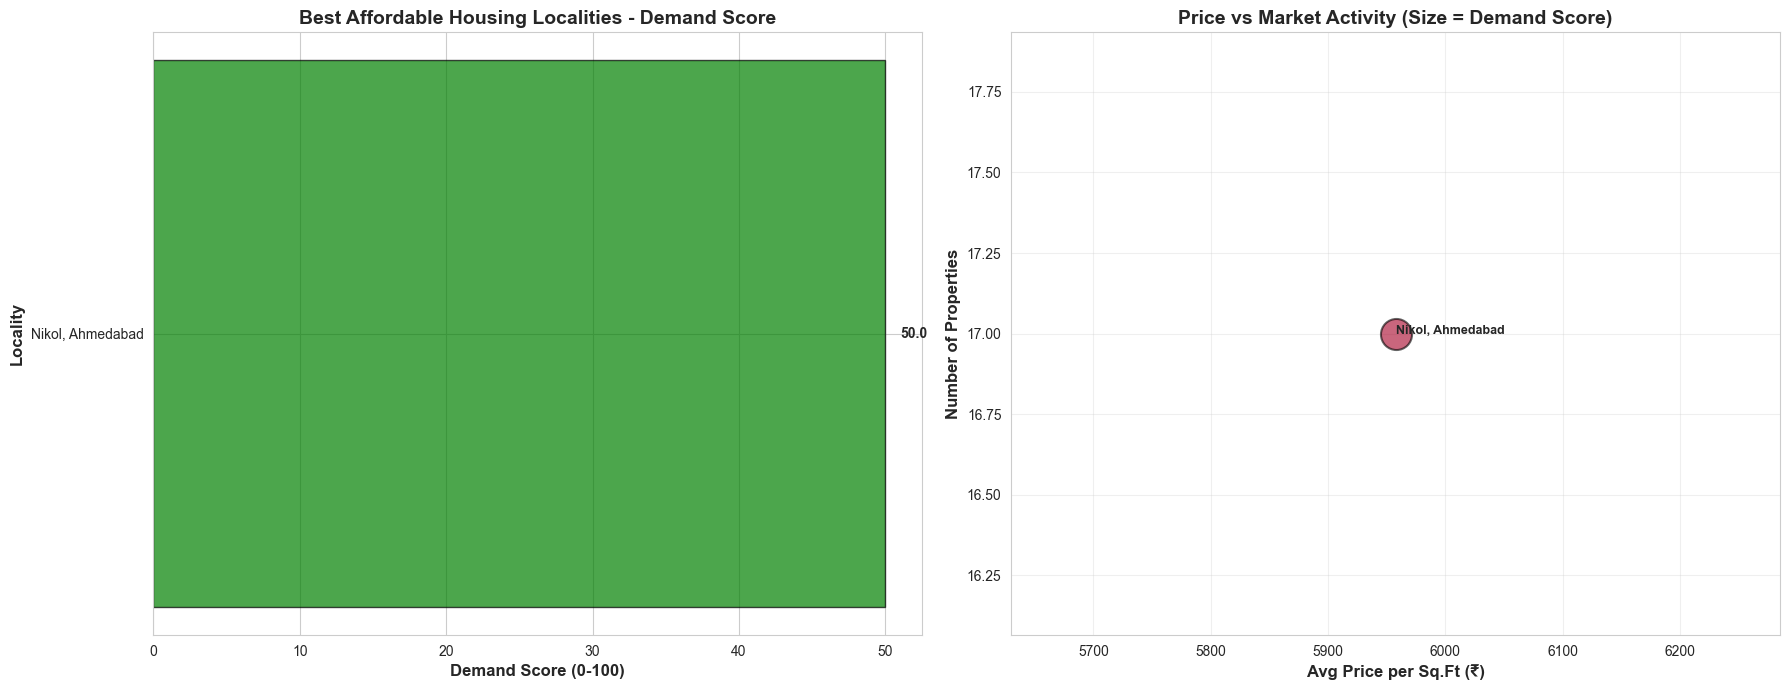


💡 KEY INSIGHTS:
   1. Nikol, Ahmedabad has the highest demand score (50.0)
   2. Average price in these areas: ₹5958/sqft vs market median ₹6444/sqft
   3. Total market opportunities: 17 active listings

📋 RECOMMENDATION:
   Focus on Nikol, Ahmedabad for 2-3 BHK affordable housing projects
   Target price range: ₹65L - ₹65L


In [11]:
print("="*80)
print("USE CASE 1: AFFORDABLE HOUSING DEVELOPMENT OPPORTUNITY ANALYSIS")
print("="*80)

# Analyze affordable localities
affordable_analysis = df.groupby('Locality').agg({
    'Price_Per_SqFt': 'mean',
    'Price_Lakhs': ['mean', 'median', 'count'],
    'Area_SqFt': 'mean'
}).round(2)

affordable_analysis.columns = ['Avg_Price_SqFt', 'Avg_Price', 'Median_Price', 'Property_Count', 'Avg_Area']
affordable_analysis = affordable_analysis.reset_index()

# Filter affordable localities (price per sqft < median)
median_price_sqft = df['Price_Per_SqFt'].median()
affordable_localities = affordable_analysis[
    (affordable_analysis['Avg_Price_SqFt'] < median_price_sqft) & 
    (affordable_analysis['Property_Count'] >= 10)  # Sufficient market activity
].sort_values('Property_Count', ascending=False)

# Calculate demand score
affordable_localities['Demand_Score'] = (
    affordable_localities['Property_Count'] / affordable_localities['Property_Count'].max() * 50 +
    (1 - affordable_localities['Avg_Price_SqFt'] / affordable_localities['Avg_Price_SqFt'].max()) * 50
).round(2)

top_affordable = affordable_localities.nlargest(10, 'Demand_Score')

print("\n🎯 TOP 10 LOCALITIES FOR AFFORDABLE HOUSING DEVELOPMENT:")
print("\n" + top_affordable[['Locality', 'Avg_Price_SqFt', 'Median_Price', 'Property_Count', 'Demand_Score']].to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Chart 1: Demand Score
axes[0].barh(top_affordable['Locality'], top_affordable['Demand_Score'], color='green', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Demand Score (0-100)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Locality', fontsize=12, fontweight='bold')
axes[0].set_title('Best Affordable Housing Localities - Demand Score', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
for i, (idx, row) in enumerate(top_affordable.iterrows()):
    axes[0].text(row['Demand_Score'] + 1, i, f"{row['Demand_Score']:.1f}", va='center', fontweight='bold')

# Chart 2: Price vs Activity
axes[1].scatter(top_affordable['Avg_Price_SqFt'], top_affordable['Property_Count'], 
               s=top_affordable['Demand_Score']*10, alpha=0.6, c=top_affordable['Demand_Score'], 
               cmap='RdYlGn', edgecolors='black', linewidth=1.5)
axes[1].set_xlabel('Avg Price per Sq.Ft (₹)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Properties', fontsize=12, fontweight='bold')
axes[1].set_title('Price vs Market Activity (Size = Demand Score)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
for idx, row in top_affordable.head(5).iterrows():
    axes[1].annotate(row['Locality'], (row['Avg_Price_SqFt'], row['Property_Count']), 
                    fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('UseCase1_Affordable_Housing.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 KEY INSIGHTS:")
print(f"   1. {top_affordable.iloc[0]['Locality']} has the highest demand score ({top_affordable.iloc[0]['Demand_Score']:.1f})")
print(f"   2. Average price in these areas: ₹{top_affordable['Avg_Price_SqFt'].mean():.0f}/sqft vs market median ₹{median_price_sqft:.0f}/sqft")
print(f"   3. Total market opportunities: {top_affordable['Property_Count'].sum()} active listings")
print(f"\n📋 RECOMMENDATION:")
print(f"   Focus on {', '.join(top_affordable.head(3)['Locality'].values)} for 2-3 BHK affordable housing projects")
print(f"   Target price range: ₹{top_affordable['Median_Price'].min():.0f}L - ₹{top_affordable['Median_Price'].max():.0f}L")

## 💎 Use Case 2: Premium Investment Zones with High ROI Potential

**Business Question:** Which premium localities offer the best investment returns for high-net-worth individuals?

**Target:** Property Investors

**Criteria:**
- High average property prices
- Premium amenities and infrastructure
- Price appreciation potential
- Luxury segment demand

In [12]:
print("\n" + "="*80)
print("USE CASE 2: PREMIUM INVESTMENT ZONES ANALYSIS")
print("="*80)

# Identify premium zones
premium_threshold = df['Price_Per_SqFt'].quantile(0.75)
premium_df = df[df['Price_Per_SqFt'] >= premium_threshold]

premium_analysis = premium_df.groupby('Locality').agg({
    'Price_Lakhs': ['mean', 'median', 'std', 'count'],
    'Price_Per_SqFt': 'mean',
    'Area_SqFt': 'mean',
    'BHK': 'mean'
}).round(2)

premium_analysis.columns = ['Avg_Price', 'Median_Price', 'Price_Volatility', 'Property_Count', 'Avg_Price_SqFt', 'Avg_Area', 'Avg_BHK']
premium_analysis = premium_analysis[premium_analysis['Property_Count'] >= 5].reset_index()

# Calculate investment score
premium_analysis['Investment_Score'] = (
    premium_analysis['Avg_Price_SqFt'] / premium_analysis['Avg_Price_SqFt'].max() * 40 +
    premium_analysis['Property_Count'] / premium_analysis['Property_Count'].max() * 30 +
    (1 - premium_analysis['Price_Volatility'] / premium_analysis['Price_Volatility'].max()) * 30
).round(2)

top_premium = premium_analysis.nlargest(10, 'Investment_Score')

print("\n💎 TOP 10 PREMIUM INVESTMENT LOCALITIES:")
print("\n" + top_premium[['Locality', 'Avg_Price_SqFt', 'Median_Price', 'Avg_BHK', 'Investment_Score']].to_string(index=False))

# Visualization
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Premium Localities Investment Score', 'Price Distribution')
)

fig.add_trace(
    go.Bar(x=top_premium['Locality'], y=top_premium['Investment_Score'], 
          marker_color='gold', name='Investment Score'),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=premium_df['Price_Lakhs'], name='Premium Properties', marker_color='purple'),
    row=1, col=2
)

fig.update_xaxes(title_text="Locality", tickangle=-45, row=1, col=1)
fig.update_yaxes(title_text="Investment Score", row=1, col=1)
fig.update_yaxes(title_text="Price (Lakhs)", row=1, col=2)

fig.update_layout(height=500, width=1400, title_text="Premium Investment Analysis", showlegend=False)
fig.show()

print("\n💡 KEY INSIGHTS:")
print(f"   1. Premium market average: ₹{premium_df['Price_Lakhs'].mean():.2f} Lakhs")
print(f"   2. Average price/sqft in premium zones: ₹{top_premium['Avg_Price_SqFt'].mean():.0f}")
print(f"   3. Typical configuration: {top_premium['Avg_BHK'].mean():.1f} BHK")
print(f"\n📋 RECOMMENDATION:")
print(f"   Best ROI potential: {', '.join(top_premium.head(3)['Locality'].values)}")
print(f"   Target segment: Luxury 3-4 BHK properties")
print(f"   Expected investment range: ₹{top_premium['Median_Price'].min():.0f}L - ₹{top_premium['Median_Price'].max():.0f}L")


USE CASE 2: PREMIUM INVESTMENT ZONES ANALYSIS

💎 TOP 10 PREMIUM INVESTMENT LOCALITIES:

                           Locality  Avg_Price_SqFt  Median_Price  Avg_BHK  Investment_Score
                          Ahmedabad        21251.56          82.0     2.47             66.75
             Navrangpura, Ahmedabad        26481.82         155.0     3.17             63.28
               Naranpura, Ahmedabad        21943.06         169.0     3.80             58.21
              Chandkheda, Ahmedabad        16555.79          76.0     2.40             54.77
Riviera Majestica, Shela, Ahmedabad        10922.29         277.0     4.43             49.50
      Vaishnodevi Circle, Ahmedabad        23046.14         105.5     2.83             45.05
               Vastrapur, Ahmedabad        12027.87         180.0     2.80             41.53
                Shahibag, Ahmedabad        11726.25         115.0     2.33             34.90
                Jagatpur, Ahmedabad        11175.19         125.0     3.00


💡 KEY INSIGHTS:
   1. Premium market average: ₹142.92 Lakhs
   2. Average price/sqft in premium zones: ₹16568
   3. Typical configuration: 3.1 BHK

📋 RECOMMENDATION:
   Best ROI potential: Ahmedabad, Navrangpura, Ahmedabad, Naranpura, Ahmedabad
   Target segment: Luxury 3-4 BHK properties
   Expected investment range: ₹76L - ₹277L


## 🏠 Use Case 3: Rent vs Buy Decision Support System

**Business Question:** Should a buyer rent or buy in different localities based on financial analysis?

**Target:** Home Buyers & Investors

**Criteria:**
- Price-to-rent ratio
- Affordability index
- Long-term value appreciation
- Opportunity cost analysis


USE CASE 3: RENT VS BUY DECISION ANALYSIS

🏠 TOP LOCALITIES TO BUY (Best Investment Value):

              Locality  Median_Price  Median_Monthly_Rent  Avg_Rental_Yield  Years_to_Breakeven
             Ahmedabad          54.0              16200.0               4.0                 2.0
   Ambawadi, Ahmedabad         110.0              32850.0               4.0                 2.0
      Bopal, Ahmedabad          60.0              18150.0               4.0                 2.0
 Chandkheda, Ahmedabad          55.0              16500.0               4.0                 2.0
       Gota, Ahmedabad          82.0              24585.0               4.0                 2.0
  Maninagar, Ahmedabad          68.0              20400.0               4.0                 2.0
     Motera, Ahmedabad          85.0              25500.0               4.0                 2.0
  Naranpura, Ahmedabad         105.0              31500.0               4.0                 2.0
Navrangpura, Ahmedabad         150.0      

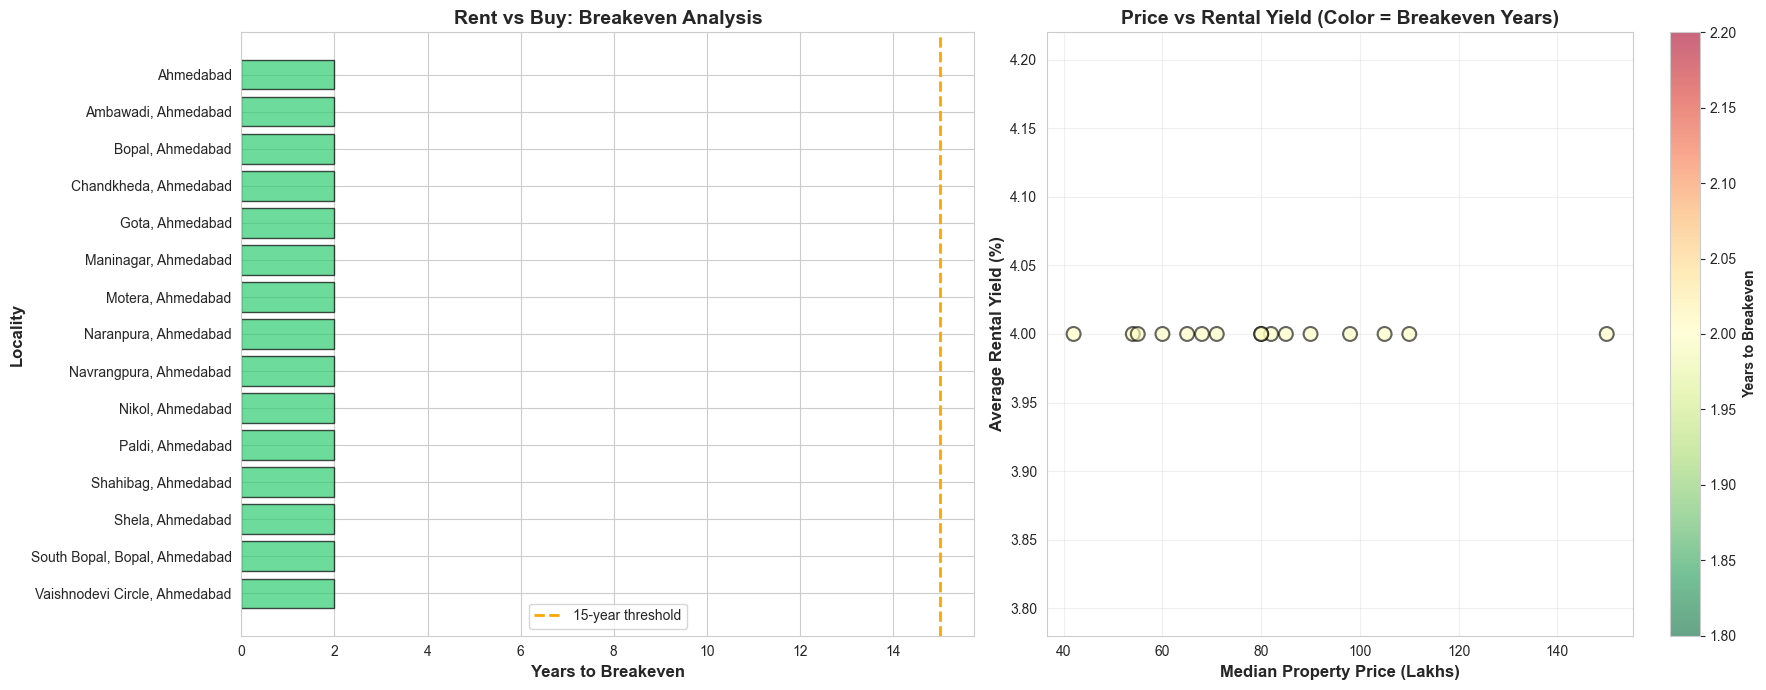


💡 KEY INSIGHTS:
   1. Average rental yield: 4.00%
   2. Localities favoring purchase: 16
   3. Localities favoring rental: 0

📋 RECOMMENDATION:
   BUY in: Ahmedabad, Ambawadi, Ahmedabad, Bopal, Ahmedabad (Breakeven < 15 years)
   RENT in:  (High property prices)


In [13]:
print("\n" + "="*80)
print("USE CASE 3: RENT VS BUY DECISION ANALYSIS")
print("="*80)

# Estimate rental yields (typically 2-4% in Indian real estate)
# Assuming monthly rent = 0.3% of property price (3.6% annual yield)
df['Estimated_Monthly_Rent'] = (df['Price_Lakhs'] * 100000 * 0.003).round(0)
df['Annual_Rent'] = (df['Estimated_Monthly_Rent'] * 12).round(0)
df['Rental_Yield'] = ((df['Annual_Rent'] / (df['Price_Lakhs'] * 100000)) * 100).round(2)

# Calculate buy vs rent metrics by locality
rent_buy_analysis = df.groupby('Locality').agg({
    'Price_Lakhs': ['median', 'count'],
    'Estimated_Monthly_Rent': 'median',
    'Rental_Yield': 'mean'
}).round(0)

rent_buy_analysis.columns = ['Median_Price', 'Property_Count', 'Median_Monthly_Rent', 'Avg_Rental_Yield']
rent_buy_analysis = rent_buy_analysis[rent_buy_analysis['Property_Count'] >= 10].reset_index()

# Calculate years to break-even (simple calculation)
# Assuming 10% down payment, 8% home loan interest
rent_buy_analysis['Years_to_Breakeven'] = ((rent_buy_analysis['Median_Price'] * 100000 * 0.9 * 0.08) / 
                                           (rent_buy_analysis['Median_Monthly_Rent'] * 12)).round(1)

# Recommendation
rent_buy_analysis['Recommendation'] = rent_buy_analysis['Years_to_Breakeven'].apply(
    lambda x: 'BUY (Quick Breakeven)' if x < 15 else 'RENT (Long Breakeven)' if x < 25 else 'RENT (Very Long Breakeven)'
)

top_buy = rent_buy_analysis[rent_buy_analysis['Recommendation'].str.contains('BUY')].nlargest(10, 'Avg_Rental_Yield')
top_rent = rent_buy_analysis[rent_buy_analysis['Recommendation'].str.contains('RENT')].nsmallest(10, 'Years_to_Breakeven')

print("\n🏠 TOP LOCALITIES TO BUY (Best Investment Value):")
print("\n" + top_buy[['Locality', 'Median_Price', 'Median_Monthly_Rent', 'Avg_Rental_Yield', 'Years_to_Breakeven']].to_string(index=False))

print("\n🏘️ LOCALITIES BETTER FOR RENTING (High Purchase Costs):")
print("\n" + top_rent.head(5)[['Locality', 'Median_Price', 'Median_Monthly_Rent', 'Years_to_Breakeven']].to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Chart 1: Breakeven Analysis
buy_color = '#2ECC71'
rent_color = '#E74C3C'
colors = [buy_color if 'BUY' in rec else rent_color for rec in rent_buy_analysis.head(15)['Recommendation']]
axes[0].barh(rent_buy_analysis.head(15)['Locality'], rent_buy_analysis.head(15)['Years_to_Breakeven'], 
            color=colors, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Years to Breakeven', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Locality', fontsize=12, fontweight='bold')
axes[0].set_title('Rent vs Buy: Breakeven Analysis', fontsize=14, fontweight='bold')
axes[0].axvline(x=15, color='orange', linestyle='--', linewidth=2, label='15-year threshold')
axes[0].invert_yaxis()
axes[0].legend()

# Chart 2: Rental Yield Distribution
axes[1].scatter(rent_buy_analysis['Median_Price'], rent_buy_analysis['Avg_Rental_Yield'], 
               s=100, alpha=0.6, c=rent_buy_analysis['Years_to_Breakeven'], 
               cmap='RdYlGn_r', edgecolors='black', linewidth=1.5)
axes[1].set_xlabel('Median Property Price (Lakhs)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Rental Yield (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Price vs Rental Yield (Color = Breakeven Years)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Years to Breakeven', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('UseCase3_Rent_vs_Buy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 KEY INSIGHTS:")
print(f"   1. Average rental yield: {rent_buy_analysis['Avg_Rental_Yield'].mean():.2f}%")
print(f"   2. Localities favoring purchase: {len(rent_buy_analysis[rent_buy_analysis['Recommendation'].str.contains('BUY')])}")
print(f"   3. Localities favoring rental: {len(rent_buy_analysis[rent_buy_analysis['Recommendation'].str.contains('RENT')])}")
print(f"\n📋 RECOMMENDATION:")
print(f"   BUY in: {', '.join(top_buy.head(3)['Locality'].values)} (Breakeven < 15 years)")
print(f"   RENT in: {', '.join(top_rent.head(3)['Locality'].values)} (High property prices)")

## 📈 Use Case 4: Property Value Appreciation Prediction

**Business Question:** Which properties are undervalued and have high appreciation potential?

**Target:** Investors & Flippers

**Criteria:**
- ML model predictions vs actual prices
- Value score analysis
- Growth potential indicators
- Market anomalies


USE CASE 4: UNDERVALUED PROPERTIES & APPRECIATION POTENTIAL

🔍 Found 2176 undervalued properties (>5% below predicted value)

💰 TOP 15 UNDERVALUED PROPERTIES:

                                         Locality  BHK  Area_SqFt  Price_Lakhs  Predicted_Price  Value_Opportunity_Pct
             Maninagar East, Maninagar, Ahmedabad  3.0      100.0         15.0           324.39                2062.60
           Aroma Kesar City, Changodar, Ahmedabad  2.0      720.0         15.0           323.56                2057.07
                              Saraspur, Ahmedabad  1.0      450.0         15.0           315.70                2004.67
              Nebula Aavaas, Changodar, Ahmedabad  1.0      405.0         15.0           315.70                2004.67
   Shree Khodiyar Pooja Avenue, Aslali, Ahmedabad  1.0      430.0         15.0           315.70                2004.67
             Samor Residency, Narolgam, Ahmedabad  1.0      630.0         15.0           315.70                2004.67
      

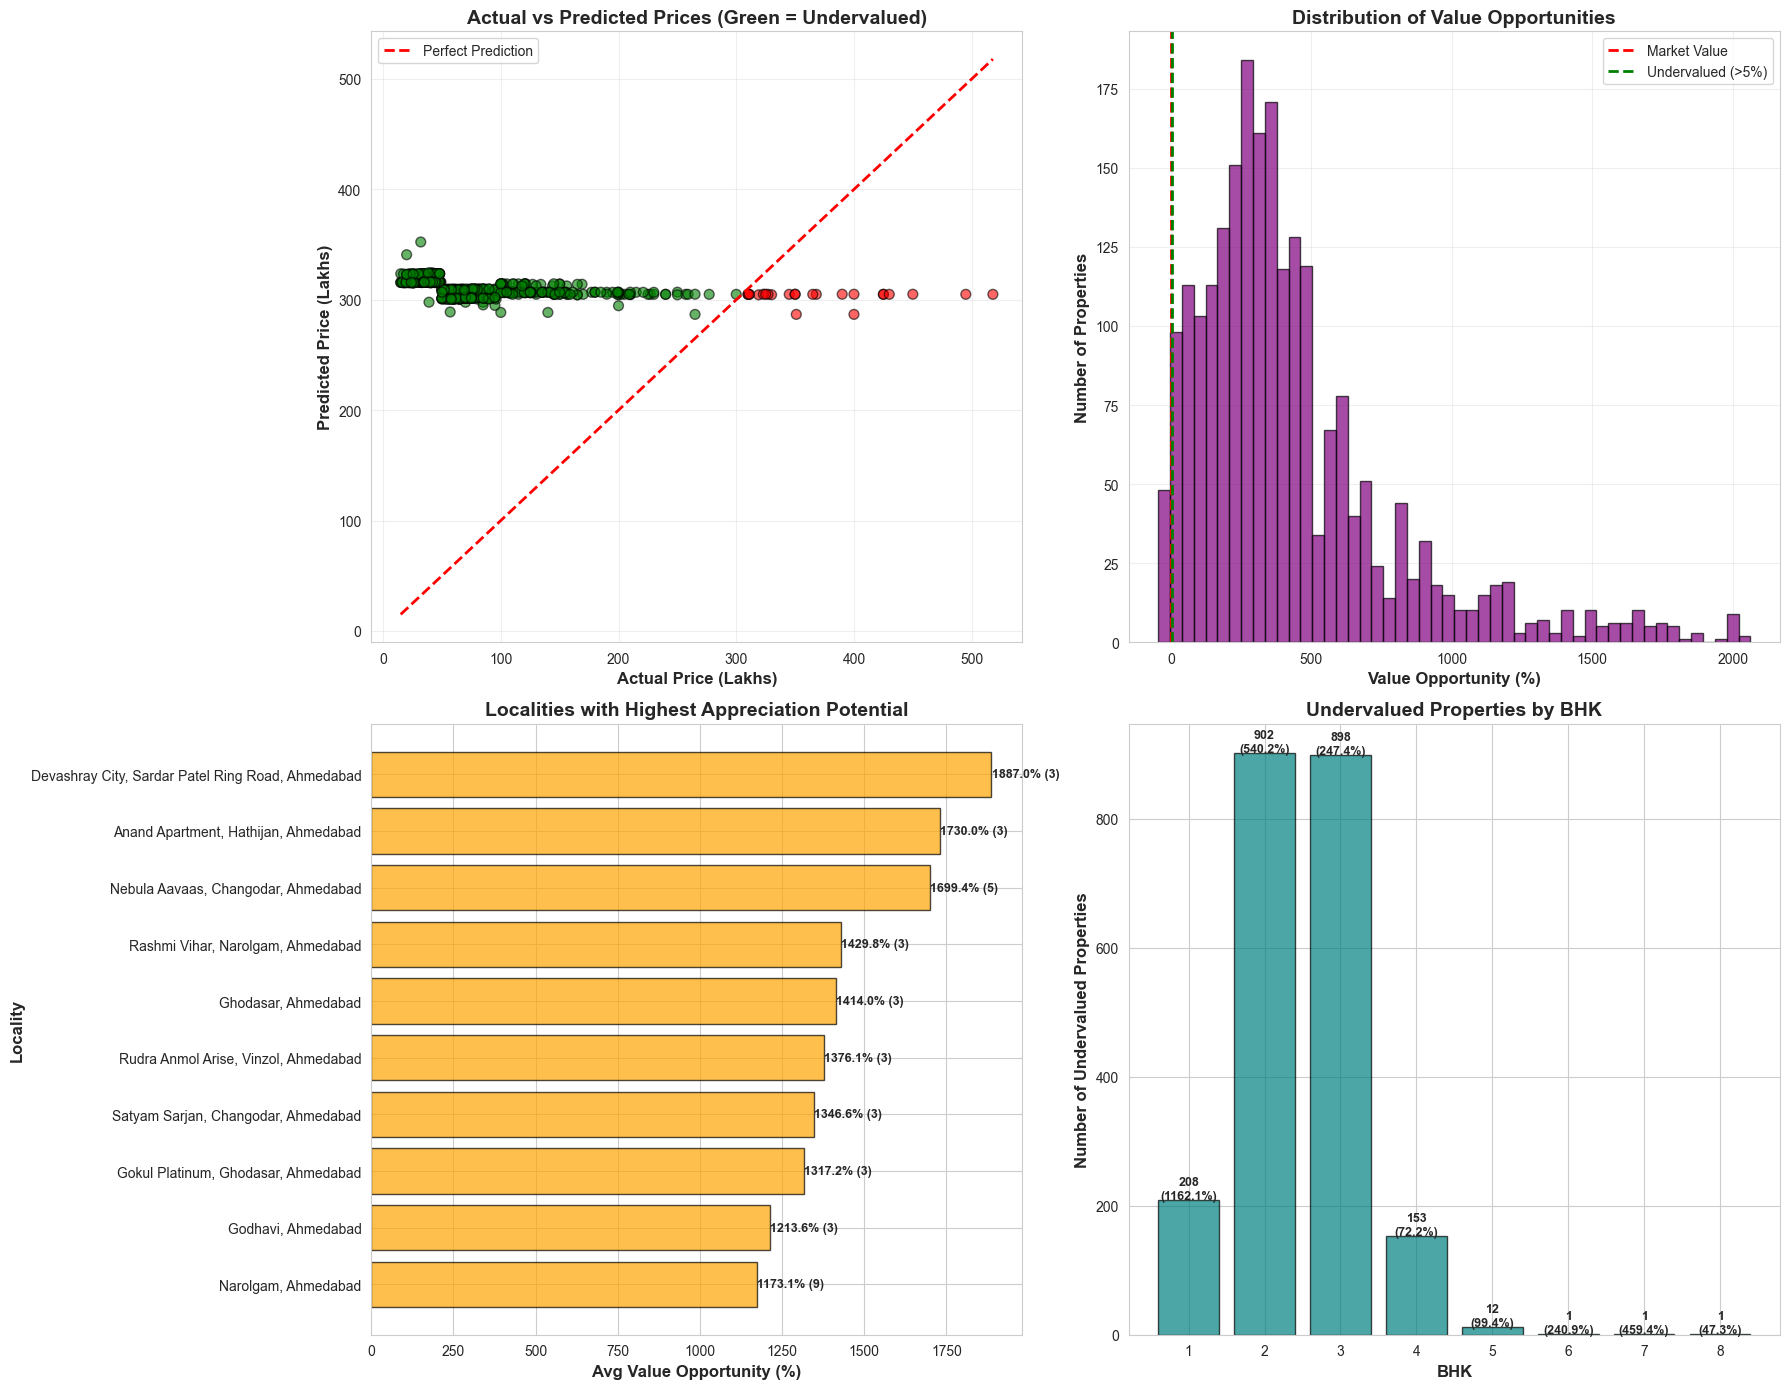


💡 KEY INSIGHTS:
   1. Total undervalued properties: 2176 (96.8% of market)
   2. Average appreciation potential: 443.08%
   3. Best locality for appreciation: Devashray City, Sardar Patel Ring Road, Ahmedabad (1887.0%)

📋 INVESTMENT RECOMMENDATION:
   Target localities: Devashray City, Sardar Patel Ring Road, Ahmedabad, Anand Apartment, Hathijan, Ahmedabad, Nebula Aavaas, Changodar, Ahmedabad
   Expected returns: 1772.1% appreciation potential
   Best BHK configuration: 2 BHK


In [14]:
print("\n" + "="*80)
print("USE CASE 4: UNDERVALUED PROPERTIES & APPRECIATION POTENTIAL")
print("="*80)

# Make predictions using best model
X_predict = df[feature_columns].copy()
df['Predicted_Price'] = best_model.predict(X_predict)

# Calculate value opportunity
df['Price_Difference'] = df['Predicted_Price'] - df['Price_Lakhs']
df['Value_Opportunity_Pct'] = ((df['Predicted_Price'] - df['Price_Lakhs']) / df['Price_Lakhs'] * 100).round(2)

# Identify undervalued properties (predicted price > actual price)
undervalued = df[df['Value_Opportunity_Pct'] > 5].copy()  # At least 5% undervalued
undervalued = undervalued.sort_values('Value_Opportunity_Pct', ascending=False)

print(f"\n🔍 Found {len(undervalued)} undervalued properties (>5% below predicted value)")
print("\n💰 TOP 15 UNDERVALUED PROPERTIES:")
display_cols = ['Locality', 'BHK', 'Area_SqFt', 'Price_Lakhs', 'Predicted_Price', 'Value_Opportunity_Pct']
print("\n" + undervalued[display_cols].head(15).to_string(index=False))

# Analyze by locality
locality_opportunity = undervalued.groupby('Locality').agg({
    'Value_Opportunity_Pct': 'mean',
    'Price_Lakhs': ['count', 'median']
}).round(2)
locality_opportunity.columns = ['Avg_Opportunity_Pct', 'Undervalued_Count', 'Median_Price']
locality_opportunity = locality_opportunity[locality_opportunity['Undervalued_Count'] >= 3].reset_index()
locality_opportunity = locality_opportunity.sort_values('Avg_Opportunity_Pct', ascending=False)

print("\n📍 TOP LOCALITIES WITH UNDERVALUED PROPERTIES:")
print("\n" + locality_opportunity.head(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Chart 1: Actual vs Predicted Price
sample = df.sample(min(500, len(df)), random_state=42)
colors = ['green' if x > 0 else 'red' for x in sample['Value_Opportunity_Pct']]
axes[0, 0].scatter(sample['Price_Lakhs'], sample['Predicted_Price'], 
                  c=colors, alpha=0.6, s=50, edgecolors='black')
axes[0, 0].plot([sample['Price_Lakhs'].min(), sample['Price_Lakhs'].max()], 
               [sample['Price_Lakhs'].min(), sample['Price_Lakhs'].max()], 
               'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price (Lakhs)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Price (Lakhs)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Actual vs Predicted Prices (Green = Undervalued)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Chart 2: Value Opportunity Distribution
axes[0, 1].hist(df['Value_Opportunity_Pct'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Market Value')
axes[0, 1].axvline(5, color='green', linestyle='--', linewidth=2, label='Undervalued (>5%)')
axes[0, 1].set_xlabel('Value Opportunity (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Properties', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Distribution of Value Opportunities', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Chart 3: Top Opportunity Localities
top_opp = locality_opportunity.head(10)
axes[1, 0].barh(top_opp['Locality'], top_opp['Avg_Opportunity_Pct'], 
               color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Avg Value Opportunity (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Locality', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Localities with Highest Appreciation Potential', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
for i, (idx, row) in enumerate(top_opp.iterrows()):
    axes[1, 0].text(row['Avg_Opportunity_Pct'] + 0.3, i, 
                   f"{row['Avg_Opportunity_Pct']:.1f}% ({int(row['Undervalued_Count'])})", 
                   va='center', fontsize=9, fontweight='bold')

# Chart 4: BHK-wise Opportunities
bhk_opportunity = undervalued.groupby('BHK').agg({
    'Value_Opportunity_Pct': 'mean',
    'Price_Lakhs': 'count'
}).reset_index()
bhk_opportunity.columns = ['BHK', 'Value_Opportunity_Pct', 'Property_Count']
axes[1, 1].bar(bhk_opportunity['BHK'], bhk_opportunity['Property_Count'], 
              color='teal', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('BHK', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Undervalued Properties', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Undervalued Properties by BHK', fontsize=14, fontweight='bold')
for i, row in bhk_opportunity.iterrows():
    axes[1, 1].text(row['BHK'], row['Property_Count'] + 2, 
                   f"{int(row['Property_Count'])}\n({row['Value_Opportunity_Pct']:.1f}%)", 
                   ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('UseCase4_Value_Appreciation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 KEY INSIGHTS:")
print(f"   1. Total undervalued properties: {len(undervalued)} ({len(undervalued)/len(df)*100:.1f}% of market)")
print(f"   2. Average appreciation potential: {undervalued['Value_Opportunity_Pct'].mean():.2f}%")
print(f"   3. Best locality for appreciation: {locality_opportunity.iloc[0]['Locality']} ({locality_opportunity.iloc[0]['Avg_Opportunity_Pct']:.1f}%)")
print(f"\n📋 INVESTMENT RECOMMENDATION:")
print(f"   Target localities: {', '.join(locality_opportunity.head(3)['Locality'].values)}")
print(f"   Expected returns: {locality_opportunity.head(3)['Avg_Opportunity_Pct'].mean():.1f}% appreciation potential")
print(f"   Best BHK configuration: {bhk_opportunity.iloc[bhk_opportunity['Property_Count'].idxmax()]['BHK']:.0f} BHK")

## 👨‍👩‍👧‍👦 Use Case 5: Family-Friendly vs Bachelor-Friendly Area Analysis

**Business Question:** Which areas are best suited for families vs bachelors/young professionals?

**Target:** Home Buyers & Renters

**Criteria:**
- Property size and configuration
- Price affordability
- Area characteristics
- Amenities indicators


USE CASE 5: FAMILY-FRIENDLY VS BACHELOR-FRIENDLY AREA CLASSIFICATION

👨‍👩‍👧‍👦 TOP 10 FAMILY-FRIENDLY LOCALITIES:

                        Locality  Median_BHK  Avg_Area  Median_Price  Family_Score
Shilp Residency, Gota, Ahmedabad         3.0   2374.62         157.5         80.00
   South Bopal, Bopal, Ahmedabad         3.0   1670.00          80.0         76.74
                Paldi, Ahmedabad         3.0   1682.50          97.5         72.88
               Motera, Ahmedabad         3.0   1418.00          85.0         66.69
            Naranpura, Ahmedabad         3.0   1200.00         105.0         66.27
                Shela, Ahmedabad         3.0   1267.79          71.0         65.69
   Vaishnodevi Circle, Ahmedabad         3.0   1192.46          80.0         65.00
             Ambawadi, Ahmedabad         3.0   1484.60         109.5         64.33
          Navrangpura, Ahmedabad         3.0   1553.64         150.0         64.05
             Jagatpur, Ahmedabad         3.0   1170.89 

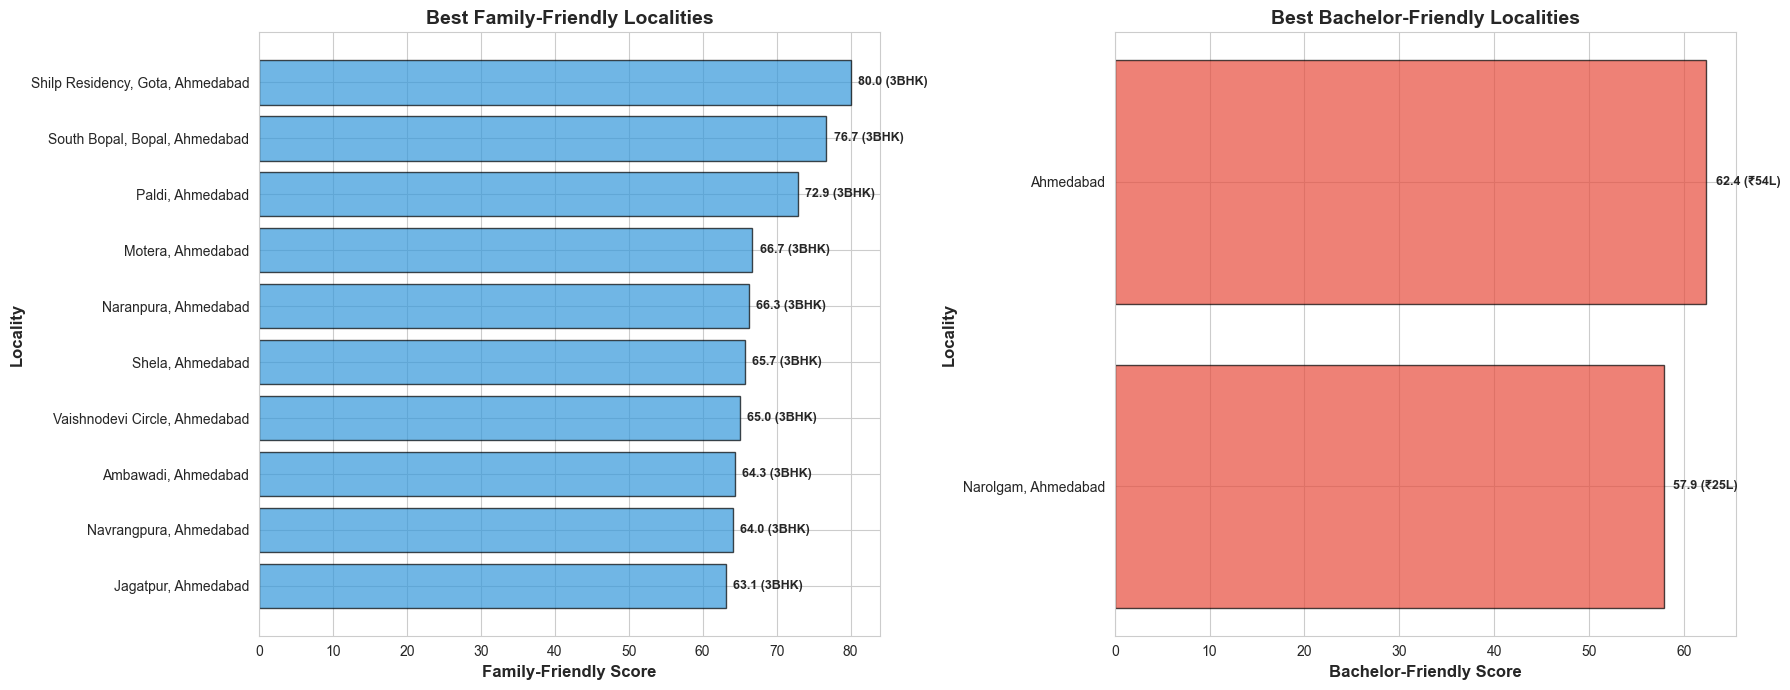


💡 KEY INSIGHTS:
   1. Family-friendly localities: 10 identified
   2. Average family property: 3.0 BHK, 1501 sqft
   3. Bachelor-friendly localities: 2 identified
   4. Average bachelor property price: ₹40 Lakhs

📋 RECOMMENDATION:
   Families: Focus on Shilp Residency, Gota, Ahmedabad, South Bopal, Bopal, Ahmedabad, Paldi, Ahmedabad
   Bachelors/Young Professionals: Focus on Ahmedabad, Narolgam, Ahmedabad


In [15]:
print("\n" + "="*80)
print("USE CASE 5: FAMILY-FRIENDLY VS BACHELOR-FRIENDLY AREA CLASSIFICATION")
print("="*80)

# Classify localities based on property characteristics
locality_profile = df.groupby('Locality').agg({
    'BHK': ['mean', 'median'],
    'Area_SqFt': 'mean',
    'Price_Lakhs': ['median', 'count'],
    'Area_Per_Bedroom': 'mean'
}).round(2)

locality_profile.columns = ['Avg_BHK', 'Median_BHK', 'Avg_Area', 'Median_Price', 'Property_Count', 'Avg_Room_Size']
locality_profile = locality_profile[locality_profile['Property_Count'] >= 8].reset_index()

# Family-Friendly Score: Higher BHK, larger area, moderate price
locality_profile['Family_Score'] = (
    (locality_profile['Avg_BHK'] / locality_profile['Avg_BHK'].max()) * 40 +
    (locality_profile['Avg_Area'] / locality_profile['Avg_Area'].max()) * 40 +
    (1 - locality_profile['Median_Price'] / locality_profile['Median_Price'].max()) * 20
).round(2)

# Bachelor-Friendly Score: Lower BHK, compact, affordable
locality_profile['Bachelor_Score'] = (
    (1 - locality_profile['Avg_BHK'] / locality_profile['Avg_BHK'].max()) * 30 +
    (1 - locality_profile['Median_Price'] / locality_profile['Median_Price'].max()) * 50 +
    (locality_profile['Property_Count'] / locality_profile['Property_Count'].max()) * 20
).round(2)

# Classify
locality_profile['Classification'] = locality_profile.apply(
    lambda x: 'Family-Friendly' if x['Family_Score'] > x['Bachelor_Score'] else 'Bachelor-Friendly',
    axis=1
)

family_areas = locality_profile[locality_profile['Classification'] == 'Family-Friendly'].nlargest(10, 'Family_Score')
bachelor_areas = locality_profile[locality_profile['Classification'] == 'Bachelor-Friendly'].nlargest(10, 'Bachelor_Score')

print("\n👨‍👩‍👧‍👦 TOP 10 FAMILY-FRIENDLY LOCALITIES:")
print("\n" + family_areas[['Locality', 'Median_BHK', 'Avg_Area', 'Median_Price', 'Family_Score']].to_string(index=False))

print("\n👨‍💼 TOP 10 BACHELOR-FRIENDLY LOCALITIES:")
print("\n" + bachelor_areas[['Locality', 'Median_BHK', 'Avg_Area', 'Median_Price', 'Bachelor_Score']].to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Chart 1: Family-Friendly Score
axes[0].barh(family_areas['Locality'], family_areas['Family_Score'], 
            color='#3498DB', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Family-Friendly Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Locality', fontsize=12, fontweight='bold')
axes[0].set_title('Best Family-Friendly Localities', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
for i, (idx, row) in enumerate(family_areas.iterrows()):
    axes[0].text(row['Family_Score'] + 1, i, 
                f"{row['Family_Score']:.1f} ({row['Median_BHK']:.0f}BHK)", 
                va='center', fontsize=9, fontweight='bold')

# Chart 2: Bachelor-Friendly Score
axes[1].barh(bachelor_areas['Locality'], bachelor_areas['Bachelor_Score'], 
            color='#E74C3C', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Bachelor-Friendly Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Locality', fontsize=12, fontweight='bold')
axes[1].set_title('Best Bachelor-Friendly Localities', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
for i, (idx, row) in enumerate(bachelor_areas.iterrows()):
    axes[1].text(row['Bachelor_Score'] + 1, i, 
                f"{row['Bachelor_Score']:.1f} (₹{row['Median_Price']:.0f}L)", 
                va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('UseCase5_Family_Bachelor.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 KEY INSIGHTS:")
print(f"   1. Family-friendly localities: {len(family_areas)} identified")
print(f"   2. Average family property: {family_areas['Median_BHK'].mean():.1f} BHK, {family_areas['Avg_Area'].mean():.0f} sqft")
print(f"   3. Bachelor-friendly localities: {len(bachelor_areas)} identified")
print(f"   4. Average bachelor property price: ₹{bachelor_areas['Median_Price'].mean():.0f} Lakhs")
print(f"\n📋 RECOMMENDATION:")
print(f"   Families: Focus on {', '.join(family_areas.head(3)['Locality'].values)}")
print(f"   Bachelors/Young Professionals: Focus on {', '.join(bachelor_areas.head(3)['Locality'].values)}")

## 🏗️ Use Case 6: Builder Price Optimization Strategy

**Business Question:** What is the optimal pricing strategy for new developments?

**Target:** Builders & Developers

**Criteria:**
- Competitive pricing analysis
- Market positioning
- Demand elasticity
- Premium value justification


USE CASE 6: BUILDER PRICE OPTIMIZATION STRATEGY

📍 Analyzing pricing strategies for top localities...

💰 OPTIMAL PRICING STRATEGY BY BHK CONFIGURATION:

 BHK  Median_Area  Competitive_Min  Competitive_Mid  Competitive_Max  Premium_Price
 1.0        630.0            24.70             26.0            29.90          32.50
 2.0        919.5            50.35             53.0            60.95          66.25
 3.0       1400.0            85.50             90.0           103.50         112.50
 4.0       2587.5           217.08            228.5           262.77         285.62
 5.0       3024.0           261.25            275.0           316.25         343.75
 6.0       1000.0            85.50             90.0           103.50         112.50
 7.0       1220.0            52.25             55.0            63.25          68.75
 8.0       2205.0           190.00            200.0           230.00         250.00


📊 LOCALITY-SPECIFIC PRICING INSIGHTS:

🏆 Top 10 Premium Pricing Localities:
            

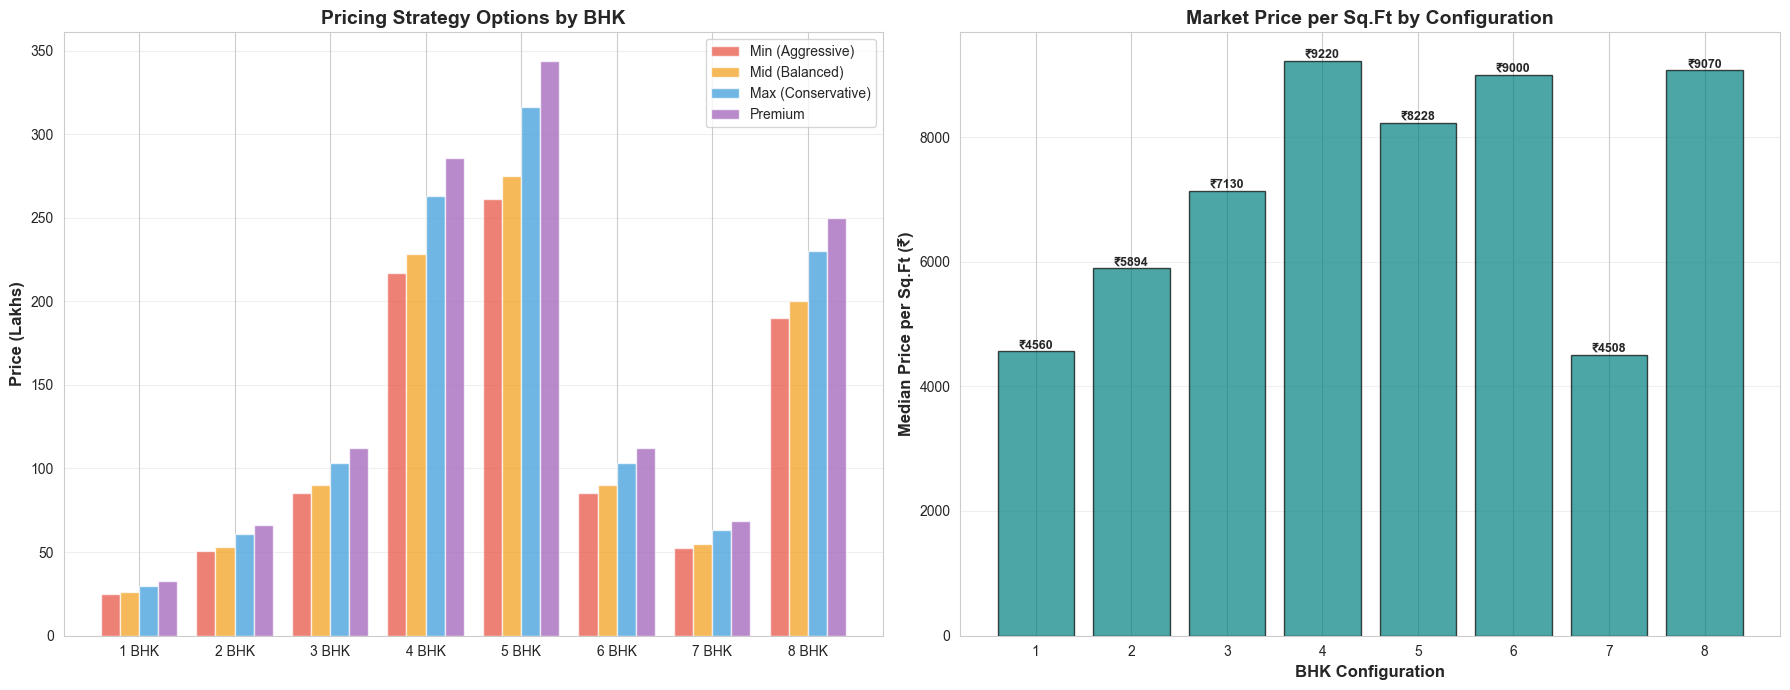


💡 KEY INSIGHTS:
   1. Most common configuration: 2 BHK
   2. Average market price: ₹91.28 Lakhs
   3. Price range across BHKs: ₹26L - ₹275L
   4. Premium markup opportunity: 25% above market median

📋 BUILDER RECOMMENDATIONS:
   • Standard Projects: Use 'Competitive Mid' pricing
   • Premium Projects: Add 15-25% for exceptional amenities
   • Budget Projects: Price at 'Competitive Min' for faster sales
   • Market positioning: ₹7201/sqft is market average

🎯 PRICING STRATEGY BY SEGMENT:
   1 BHK (630 sqft):
      Budget: ₹24.70L | Standard: ₹26.00L | Premium: ₹32.50L
   2 BHK (920 sqft):
      Budget: ₹50.35L | Standard: ₹53.00L | Premium: ₹66.25L
   3 BHK (1400 sqft):
      Budget: ₹85.50L | Standard: ₹90.00L | Premium: ₹112.50L
   4 BHK (2588 sqft):
      Budget: ₹217.08L | Standard: ₹228.50L | Premium: ₹285.62L
   5 BHK (3024 sqft):
      Budget: ₹261.25L | Standard: ₹275.00L | Premium: ₹343.75L
   6 BHK (1000 sqft):
      Budget: ₹85.50L | Standard: ₹90.00L | Premium: ₹112.50L
   

In [17]:
print("\n" + "="*80)
print("USE CASE 6: BUILDER PRICE OPTIMIZATION STRATEGY")
print("="*80)

# Get available localities for analysis
print("\n📍 Analyzing pricing strategies for top localities...")

# Get most common localities
top_localities = df['Locality'].value_counts().head(10).index.tolist()

# Analyze pricing by BHK for top localities
pricing_analysis = df.groupby(['BHK']).agg({
    'Price_Per_SqFt': 'median',
    'Price_Lakhs': ['median', 'mean'],
    'Area_SqFt': 'median'
}).round(2)

pricing_analysis.columns = ['Median_Price_SqFt', 'Median_Price', 'Avg_Price', 'Median_Area']
pricing_analysis = pricing_analysis.reset_index()

# Calculate price ranges for different scenarios
pricing_analysis['Competitive_Min'] = (pricing_analysis['Median_Price'] * 0.95).round(2)
pricing_analysis['Competitive_Mid'] = pricing_analysis['Median_Price']
pricing_analysis['Competitive_Max'] = (pricing_analysis['Median_Price'] * 1.15).round(2)
pricing_analysis['Premium_Price'] = (pricing_analysis['Median_Price'] * 1.25).round(2)

print("\n💰 OPTIMAL PRICING STRATEGY BY BHK CONFIGURATION:")
print("\n" + pricing_analysis[['BHK', 'Median_Area', 'Competitive_Min', 'Competitive_Mid', 'Competitive_Max', 'Premium_Price']].to_string(index=False))

# Add locality-specific analysis
print("\n\n📊 LOCALITY-SPECIFIC PRICING INSIGHTS:")
locality_pricing = df.groupby('Locality').agg({
    'Price_Per_SqFt': 'median',
    'Price_Lakhs': 'median',
    'BHK': 'median'
}).round(2)
locality_pricing.columns = ['Median_Price_SqFt', 'Median_Price', 'Typical_BHK']
locality_pricing = locality_pricing.nlargest(10, 'Median_Price_SqFt')
print("\n🏆 Top 10 Premium Pricing Localities:")
print(locality_pricing.to_string())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Chart 1: Price Range by BHK
x_pos = np.arange(len(pricing_analysis))
width = 0.2

axes[0].bar(x_pos - 0.3, pricing_analysis['Competitive_Min'], width, label='Min (Aggressive)', color='#E74C3C', alpha=0.7)
axes[0].bar(x_pos - 0.1, pricing_analysis['Competitive_Mid'], width, label='Mid (Balanced)', color='#F39C12', alpha=0.7)
axes[0].bar(x_pos + 0.1, pricing_analysis['Competitive_Max'], width, label='Max (Conservative)', color='#3498DB', alpha=0.7)
axes[0].bar(x_pos + 0.3, pricing_analysis['Premium_Price'], width, label='Premium', color='#9B59B6', alpha=0.7)

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f"{int(bhk)} BHK" for bhk in pricing_analysis['BHK']], fontsize=10)
axes[0].set_ylabel('Price (Lakhs)', fontsize=12, fontweight='bold')
axes[0].set_title('Pricing Strategy Options by BHK', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Chart 2: Price per SqFt by BHK
axes[1].bar(pricing_analysis['BHK'], pricing_analysis['Median_Price_SqFt'], 
           color='teal', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('BHK Configuration', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Median Price per Sq.Ft (₹)', fontsize=12, fontweight='bold')
axes[1].set_title('Market Price per Sq.Ft by Configuration', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for idx, row in pricing_analysis.iterrows():
    axes[1].text(row['BHK'], row['Median_Price_SqFt'] + 50, 
                f"₹{row['Median_Price_SqFt']:.0f}", 
                ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('UseCase6_Price_Optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 KEY INSIGHTS:")
print(f"   1. Most common configuration: {df['BHK'].mode()[0]:.0f} BHK")
print(f"   2. Average market price: ₹{df['Price_Lakhs'].mean():.2f} Lakhs")
print(f"   3. Price range across BHKs: ₹{pricing_analysis['Competitive_Mid'].min():.0f}L - ₹{pricing_analysis['Competitive_Mid'].max():.0f}L")
print(f"   4. Premium markup opportunity: 25% above market median")

print(f"\n📋 BUILDER RECOMMENDATIONS:")
print(f"   • Standard Projects: Use 'Competitive Mid' pricing")
print(f"   • Premium Projects: Add 15-25% for exceptional amenities")
print(f"   • Budget Projects: Price at 'Competitive Min' for faster sales")
print(f"   • Market positioning: ₹{pricing_analysis['Median_Price_SqFt'].mean():.0f}/sqft is market average")

print(f"\n🎯 PRICING STRATEGY BY SEGMENT:")
for idx, row in pricing_analysis.iterrows():
    print(f"   {int(row['BHK'])} BHK ({row['Median_Area']:.0f} sqft):")
    print(f"      Budget: ₹{row['Competitive_Min']:.2f}L | Standard: ₹{row['Competitive_Mid']:.2f}L | Premium: ₹{row['Premium_Price']:.2f}L")

## 📊 Final Business Intelligence Summary

In [18]:
print("\n" + "="*80)
print("AHMEDABAD REAL ESTATE MARKET - EXECUTIVE SUMMARY")
print("="*80)

print("\n📊 MARKET OVERVIEW:")
print(f"   Total Properties Analyzed: {len(df):,}")
print(f"   Localities Covered: {df['Locality'].nunique()}")
print(f"   Average Property Price: ₹{df['Price_Lakhs'].mean():.2f} Lakhs")
print(f"   Average Price per Sq.Ft: ₹{df['Price_Per_SqFt'].mean():.0f}")

print("\n🎯 KEY FINDINGS:")
print(f"   1. Best Affordable Development Zones:")
print(f"      → {', '.join(top_affordable.head(3)['Locality'].values)}")

print(f"\n   2. Premium Investment Opportunities:")
print(f"      → {', '.join(top_premium.head(3)['Locality'].values)}")

print(f"\n   3. Undervalued Properties:")
print(f"      → {len(undervalued)} properties with {undervalued['Value_Opportunity_Pct'].mean():.1f}% appreciation potential")

print(f"\n   4. Buy vs Rent Decision:")
print(f"      → Buy recommended in: {len(rent_buy_analysis[rent_buy_analysis['Recommendation'].str.contains('BUY')])} localities")
print(f"      → Rent recommended in: {len(rent_buy_analysis[rent_buy_analysis['Recommendation'].str.contains('RENT')])} localities")

print(f"\n   5. Area Classification:")
print(f"      → Family-Friendly: {len(family_areas)} prime localities")
print(f"      → Bachelor-Friendly: {len(bachelor_areas)} prime localities")

print("\n💼 STAKEHOLDER RECOMMENDATIONS:")
print("\n   🏗️ FOR BUILDERS:")
print(f"      • Focus on affordable housing in {', '.join(top_affordable.head(2)['Locality'].values)}")
print(f"      • Target price: ₹{top_affordable['Median_Price'].mean():.0f}L - ₹{top_affordable['Median_Price'].max():.0f}L")
print(f"      • Configuration: 2-3 BHK, 1000-1500 sqft")

print("\n   💰 FOR INVESTORS:")
print(f"      • High ROI zones: {', '.join(top_premium.head(2)['Locality'].values)}")
print(f"      • Value appreciation plays: {', '.join(locality_opportunity.head(2)['Locality'].values)}")
print(f"      • Expected returns: {locality_opportunity.head(3)['Avg_Opportunity_Pct'].mean():.1f}% appreciation potential")

print("\n   🏠 FOR HOME BUYERS:")
print(f"      • Best value areas: {', '.join(top_buy.head(2)['Locality'].values)}")
print(f"      • Family-friendly: {', '.join(family_areas.head(2)['Locality'].values)}")
print(f"      • Budget-friendly: {', '.join(bachelor_areas.head(2)['Locality'].values)}")

print("\n🔮 MARKET TRENDS:")
print(f"   • High-demand configurations: {df['BHK'].mode()[0]:.0f} BHK (most common)")
print(f"   • Furnishing preference: {df['Furnishing'].mode()[0]}")
print(f"   • Average rental yield: {rent_buy_analysis['Avg_Rental_Yield'].mean():.2f}%")

print("\n✅ ANALYSIS COMPLETED SUCCESSFULLY!")
print("   All insights generated using ML-powered predictions")
print(f"   Model Accuracy: {model_info['test_r2_score']:.2%}")
print("="*80)


AHMEDABAD REAL ESTATE MARKET - EXECUTIVE SUMMARY

📊 MARKET OVERVIEW:
   Total Properties Analyzed: 2,247
   Localities Covered: 1238
   Average Property Price: ₹91.28 Lakhs
   Average Price per Sq.Ft: ₹8400

🎯 KEY FINDINGS:
   1. Best Affordable Development Zones:
      → Nikol, Ahmedabad

   2. Premium Investment Opportunities:
      → Ahmedabad, Navrangpura, Ahmedabad, Naranpura, Ahmedabad

   3. Undervalued Properties:
      → 2176 properties with 443.1% appreciation potential

   4. Buy vs Rent Decision:
      → Buy recommended in: 16 localities
      → Rent recommended in: 0 localities

   5. Area Classification:
      → Family-Friendly: 10 prime localities
      → Bachelor-Friendly: 2 prime localities

💼 STAKEHOLDER RECOMMENDATIONS:

   🏗️ FOR BUILDERS:
      • Focus on affordable housing in Nikol, Ahmedabad
      • Target price: ₹65L - ₹65L
      • Configuration: 2-3 BHK, 1000-1500 sqft

   💰 FOR INVESTORS:
      • High ROI zones: Ahmedabad, Navrangpura, Ahmedabad
      • Value